In [2]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [4]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 74])
Test
torch.Size([2500, 20, 74])


In [5]:
# Customize cfg here...
# Now build...

def cfg_base(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.latent_dim = dim
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

cfg.training.epochs = 7001
cfg.tbfm.module.basis_depth = 3
cfg.tbfm.training.lambda_fro = 0.03
cfg.tbfm.module

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [6]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)
    # model_save_path="1st.torch")

---- 0 0.8801458477973938 0.8480079770088196 0.5622912049293518 0.6216412782669067
---- 1000 0.5662172436714172 0.6930009126663208 0.657871663570404 0.6905261278152466
---- 2000 0.5100260972976685 0.660120964050293 0.697810560464859 0.7047433257102966
---- 3000 0.4979768395423889 0.6599372625350952 0.7065992057323456 0.7052595615386963
---- 4000 0.47709688544273376 0.6601561903953552 0.7216906845569611 0.7050421237945557
---- 5000 0.4606190323829651 0.6664798259735107 0.7265018224716187 0.702998161315918
---- 6000 0.44496700167655945 0.6721756458282471 0.7337864339351654 0.7009533643722534
---- 7000 0.4359128475189209 0.6851040124893188 0.7376975417137146 0.6958239078521729
Final: 0.6872650384902954 0.6947660446166992


In [23]:
torch.save(embeddings_stim, "es_1.torch")
torch.save(results, "r_1.torch")
torch.save(held_in_session_ids, "hisi_1.torch")

In [7]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150918_Session1_M1': 0.7131462693214417, 'MonkeyG_20150925_Session2_S1': 0.676385760307312}
0.676385760307312


In [34]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyG_20150918_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyG_20150918_Session1_M1'])


tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.3377, 0.3512, 0.3642], device='cuda:0')
tensor([ 0.7712, -0.7046, -0.7613,  0.7412,  0.6856,  0.6664,  0.7722,  0.8088,
         0.7046,  0.7328,  0.5709, -0.5926, -0.5403, -0.7436,  0.7682],
       device='cuda:0')
tensor([ 1.0626, -0.8583, -1.0080,  0.9085,  0.8650,  1.0534,  0.8276,  1.0314,
         0.9266,  0.9135,  1.0567, -1.0951, -0.9346, -0.8047,  0.9804],
       device='cuda:0')


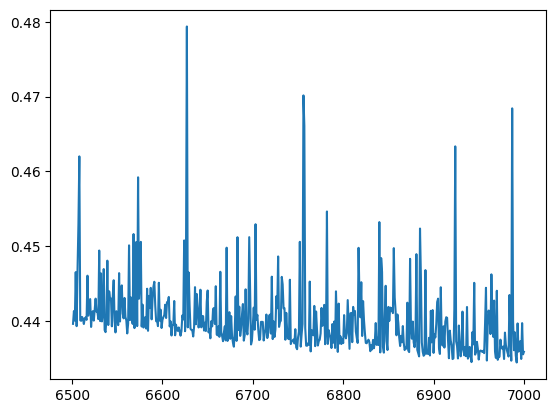

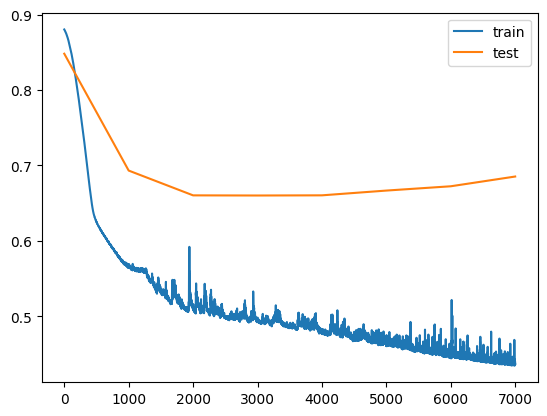

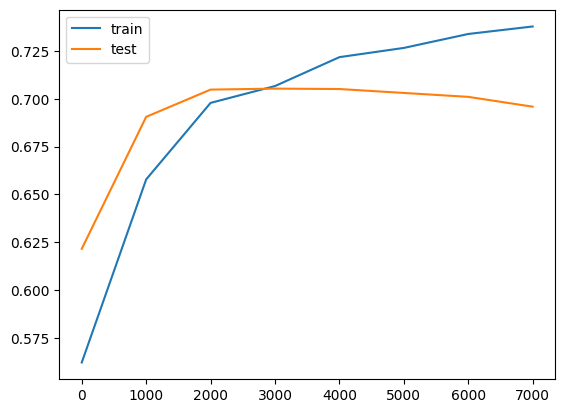

In [8]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

tensor([-0.8332, -0.8654, -0.9052, -0.9113, -0.9548, -0.9518, -0.9560, -0.9626,
        -0.9545, -0.9718], device='cuda:0')
------
------
tensor([-0.6451,  0.6416, -0.7499, -0.7144,  0.7763, -0.5670,  0.9185,  0.7118,
         0.6785,  0.5144], device='cuda:0') tensor([ 0.9085, -0.6576,  0.9769,  0.7344, -0.9194,  0.7553, -0.7266, -0.6181,
        -0.8900, -1.0059], device='cuda:0')
tensor([-1.0446, -1.0676, -1.1543, -1.1977, -1.2326, -1.3065, -1.3390, -1.3655,
        -1.4067, -1.3984], device='cuda:0')


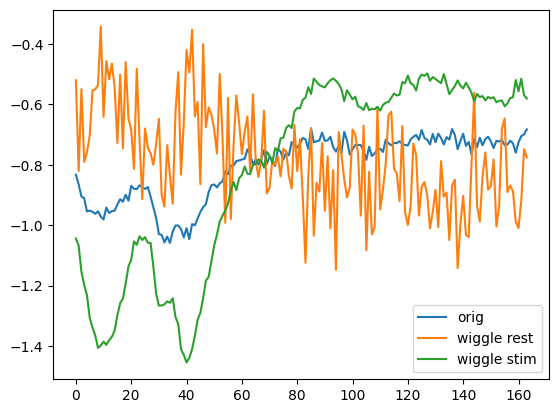

In [9]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -1.5
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

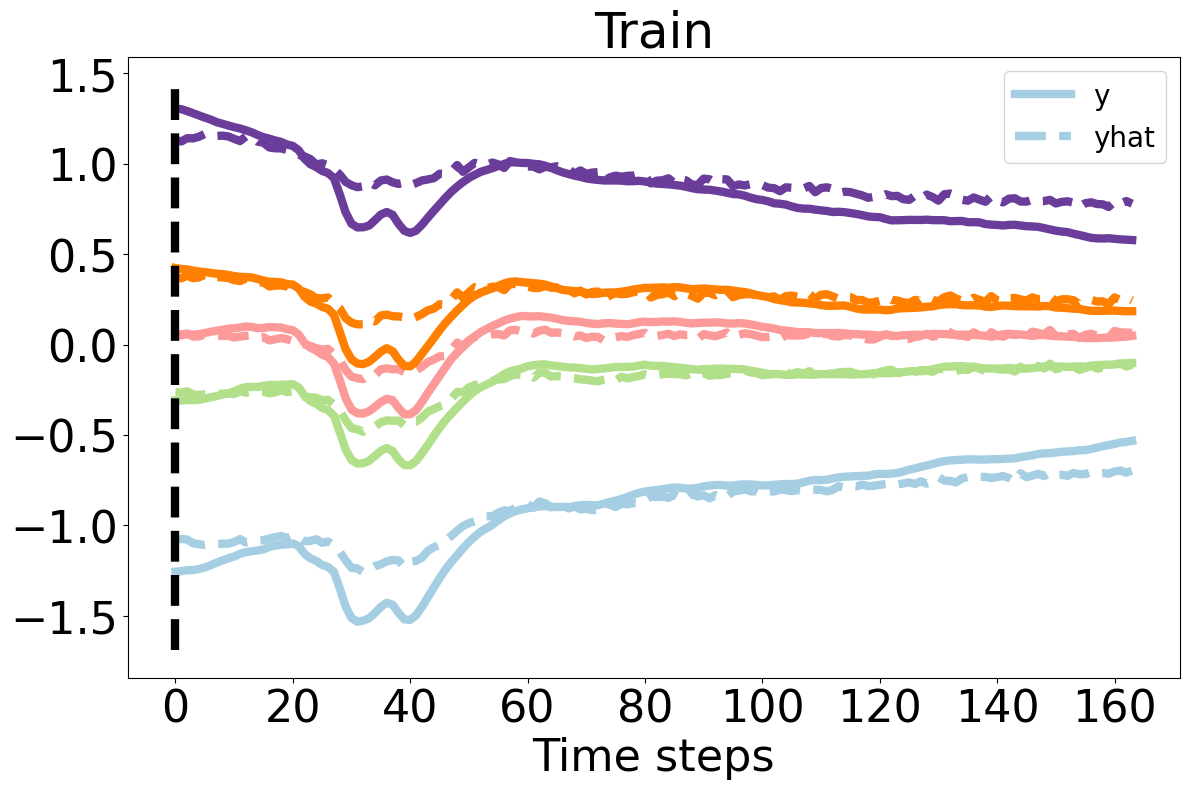

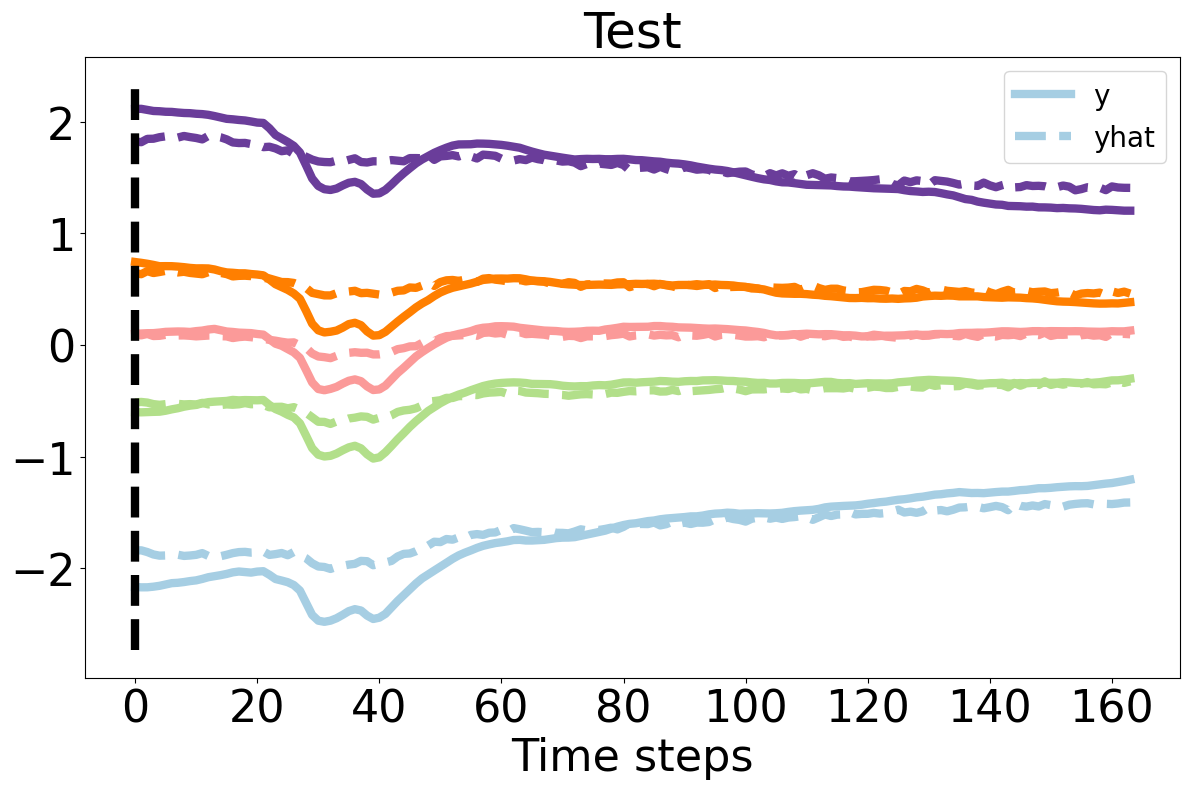

In [10]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)

In [ ]:
# Try:
# cfg.training.grad_clip = 2.0, 7.0
# cfg.tbfm.training.lambda_ortho = 0.01, 0.05, 0.1
# cfg.tbfm.module.num_bases = 15, 20, 25

for grad_clip in (2.0,):
    for num_bases in (15, 20, 25):
        for lambda_ortho in (0.01, 0.05, 0.1):
            print("---------------", grad_clip, num_bases, lambda_ortho)

            # cfg.tbfm.training.lambda_fro = regweight
            cfg.tbfm.module.num_bases = num_bases
            cfg.training.grad_clip = grad_clip
            # cfg.latent_dim = latent_dim
            # cfg.tbfm.training.optim.lr_head = lr_head
            cfg.tbfm.training.lambda_ortho = lambda_ortho
            cfg.tbfm.module.use_film_bases = True
            # cfg.ae.training.coadapt = True
            cfg.training.epochs = 20001

            ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
            model_optims = multisession.get_optims(cfg, ms)
            
            embeddings_stim, results = multisession.train_from_cfg(
                cfg,
                ms,
                data_train,
                model_optims,
                embeddings_rest,
                data_test=data_test,
                test_interval=5000,
                epochs=20001,
                )
            torch.save(results, f"res_{grad_clip}_{num_bases}_{lambda_ortho}.torch")

            del model_optims, ms

--------------- 2.0 15 0.01
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1330499649047852 0.9247554540634155 0.03832010179758072 0.061805590987205505
basis_weighting.weight         grad_norm=2.0000e+00, weight_norm=2.1510e+00, ratio=9.2982e-01
basis_weighting.bias           grad_norm=6.7800e-02, weight_norm=3.8891e+00, ratio=1.7433e-02
bases.in_layer.weight          grad_norm=4.7441e-03, weight_norm=3.3024e+00, ratio=1.4365e-03
bases.in_layer.bias            grad_norm=1.5774e-03, weight_norm=1.0543e+00, ratio=1.4962e-03
bases.hiddens.0.weight         grad_norm=1.9571e-03, weight_norm=3.9004e+00, ratio=5.0177e-04
bases.hiddens.0.bias           grad_norm=8.5569e-04, weight_norm=7.5115e-01, ratio=1.1392e-03
bases.hiddens.1.weight         grad_norm=1.9006e-03, weight_norm=3.8063e+00, ratio=4.9934e-04
bases.hiddens.1.bias           grad_norm=6.2266e-04, weight_norm=7.2910e-01, ratio=8.5402e-04
bases.out_layer.weight         

In [10]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.35666774378882515, './res_0.05_50_0.0003_0.2.torch')
(0.35697651902834576, './res_0.01_70_0.0003_0.3.torch')
(0.3569850954744551, './res_0.01_70_0.0001_0.1.torch')
(0.35736728376812404, './res_0.01_70_0.0001_0.3.torch')
(0.357471548848682, './res_0.01_50_0.0003_0.1.torch')
(0.35761067602369523, './res_0.01_70_0.0002_0.2.torch')
(0.35779477490319145, './res_0.01_70_0.0003_0.2.torch')
(0.3578372299671173, './res_0.01_70_0.0003_0.1.torch')
(0.35784753163655597, './res_0.01_50_0.0003_0.2.torch')
(0.357981413602829, './res_0.01_70_0.0002_0.1.torch')


In [13]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=10000, data_test=data_test)
print(results["final_test_r2s"])

0 0.5271126627922058
100 0.3967217206954956
200 0.3967183232307434
300 0.3967171311378479
400 0.39671623706817627
500 0.39671534299850464
600 0.39671462774276733
700 0.3967139720916748
800 0.39671337604522705
900 0.3967128396034241
1000 0.39671245217323303
1100 0.396712064743042
1200 0.3967117667198181
1300 0.39671146869659424
1400 0.39671123027801514
1500 0.3967110514640808
1600 0.3967108726501465
1700 0.39671066403388977
1800 0.39671051502227783
1900 0.3967103362083435
2000 0.39671021699905396
2100 0.3967100977897644
2200 0.39670997858047485
2300 0.3967099189758301
2400 0.39670976996421814
2500 0.396709680557251
2600 0.3967095613479614
2700 0.39670950174331665
2800 0.3967093825340271
2900 0.3967093229293823
3000 0.39670926332473755
3100 0.3967091739177704
3200 0.3967091143131256
3300 0.39670902490615845
3400 0.39670896530151367
3500 0.3967089056968689
3600 0.3967088460922241
3700 0.39670878648757935
3800 0.39670872688293457
3900 0.3967086672782898
4000 0.396708607673645
4100 0.396708

tensor([-0.9109, -0.9495, -0.9578, -1.0053, -1.0043, -1.0158, -1.0197, -1.0341,
        -1.0326, -1.0269], device='cuda:0')
------
tensor([-0.6645,  0.5796,  0.6024,  0.6400, -0.7470,  0.9124, -0.6005,  0.7902,
        -0.7462, -0.7641], device='cuda:0') tensor([ 1.5857, -1.3800, -0.7904, -1.6765,  1.7719, -2.2241,  1.6433, -1.8452,
         2.0116,  1.7907], device='cuda:0')
tensor([-1.0420, -1.0980, -1.1532, -1.1713, -1.2205, -1.2610, -1.2760, -1.2698,
        -1.2809, -1.2818], device='cuda:0')


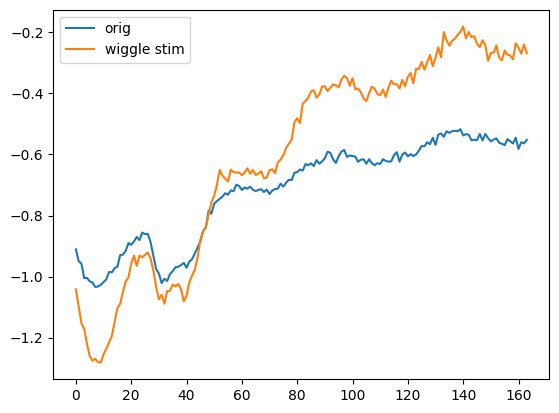

In [14]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    # preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    # plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    # print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(new_stim_embeddings, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [16]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])             
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])                    
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)



NameError: name 'results_tta' is not defined

In [21]:
print(results.keys())

dict_keys(['final_test_r2', 'final_test_r2s', 'final_test_loss', 'y_hat_test', 'y_test'])
